In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as mgrid
import matplotlib.colors as mpc
import numpy as np
import h5py

import warnings

from activ.readfile import TrackTBIFile
from activ.nmf.viz import bases_heatmap, bases_factor_order, get_percent_top, plot_bases, plot_weights,\
                          nmfplot, plot_umap_nmf_piechart, plot_umap_nmf_max, plot_umap_nmf_weight, cumulative_plot,\
                          plot_umap_nmf_weight_kde

import scipy.spatial.distance as spd
from scipy.spatial.distance import pdist, squareform

import seaborn as sns

import itertools as it
import pandas as pd
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable
import latex
from umap import UMAP

In [2]:
tbifile_path = 'tracktbi.reg_nmf.h5'
tbifile = TrackTBIFile(tbifile_path)
bm_weights, bm_bases = tbifile.nmf.bm, tbifile.nmf.bm_bases
oc_weights, oc_bases = tbifile.nmf.oc, tbifile.nmf.oc_bases

In [3]:
bm_labels = get_percent_top(tbifile.biomarker_features, bm_bases, perc=0.9)
oc_labels = get_percent_top(tbifile.outcome_features, oc_bases, perc=0.9)

In [4]:
bm_colors = sns.color_palette('Accent', 8)
bm_colors = np.array([bm_colors[i] for i in (6,5,4,2,0)])

oc_colors = sns.color_palette('Set2', 8)
oc_colors = np.array([oc_colors[i] for i in (0, 1, 6, 7, 4, 5, 2, 3)])

In [5]:
bm_emb = UMAP(n_components=2, min_dist=1.0, random_state=20001).fit_transform(tbifile.biomarkers)

binary = list()
continuous = list()
for i in range(tbifile.outcomes.shape[1]):
    # print(tbifile.outcome_features[i], np.unique(tbifile.outcomes[:, i]))
    uniq = np.unique(tbifile.outcomes[:, i])
    if len(uniq) == 2:
        binary.append(i)
    else:
        continuous.append(i)

bindist = spd.pdist(tbifile.outcomes[:, binary], metric='jaccard')
contdist = spd.pdist(tbifile.outcomes[:, continuous], metric='euclidean')

finaldist = (len(binary)*bindist/bindist.max() + len(continuous)*contdist/contdist.max())/tbifile.outcomes.shape[1]

oc_emb = UMAP(n_components=2, min_dist=0.5, random_state=20004, metric='precomputed').fit_transform(spd.squareform(finaldist))

/Users/ajtritt/anaconda3/envs/activ/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [6]:
from io import StringIO

def write_groups_pdf(labels, label_names, path):
    ltx = StringIO()
    pr = lambda x: print(x, file=ltx)


    pr("\documentclass{article}")
    pr("\\usepackage{geometry}")
    pr("\\geometry{a4paper, portrait, left=.75in, right=.75in, top=2in, bottom=2in}")

    pr("\\usepackage{multicol}")
    pr("\\begin{document}")

    for i in range(len(labels)):
        pr('\section{%s}' % label_names[i])
        pr("\\begin{multicols}{2}")
        pr("\\begin{enumerate}")
        for lbl in labels[i]:
            pr("\item %s" % lbl)
        pr("\\end{enumerate}")
        pr("\\end{multicols}")
        pr("\\newpage")

    pr("\end{document}")
    s = ltx.getvalue().replace('_', '\\textunderscore ')
    latex.build_pdf(s).save_to(path)

In [10]:
oc_bases_labels = np.array([
    'Sleep disturbance',
    'Dysphoria and\ndepression', # Depression
    #'6-month\nneurobehavioral\nimpairment', # long-term cognitive deficits
    '6-month NBI', # long-term cognitive deficits
    #'3-month\nneurobehavioral\nimpairment', # short-term cognitive deficits
    '3-month NBI', # short-term cognitive deficits
    'Dizziness and\nheadache',
    'Episodic memory',    # verbal learning
    'Good outcome',     # Recovered
    'Positive PTSD' # PTSD
])
# write_groups_pdf(oc_labels, oc_bases_labels, 'outcome_nmf_classes-2.pdf')

In [11]:
bm_bases_labels = np.array([
    'Socioeconomic\nPEMC',    # mild/discharged
    'Age-related\nPEMC',             # pre-existing health conditions and age
    'Psychiatric\nPEMC',    # pre-existing psych
    'High-severity\nTBI',        # severe injury
#    'GCS and general\nseverity measures'                     # general severity measure
    'Low-severity\nTBI'
])
#nmfplot(bm_weights, bm_bases, axes=axes, bases_labels=bm_bases_labels)
# write_groups_pdf(bm_labels, bm_bases_labels, 'biomarker_nmf_classes.pdf')

In [12]:
with h5py.File(tbifile_path, 'a') as f:
    TrackTBIFile.write_viz(f, bm_emb=bm_emb, oc_emb=oc_emb, 
                           bm_colors=bm_colors, oc_colors=oc_colors, 
                           bm_labels=bm_bases_labels, oc_labels=oc_bases_labels, overwrite=True)
    TrackTBIFile.write_feat_types(f, 
                                  {'nmf': bm_bases_labels[np.argmax(bm_bases, axis=0)]}, 
                                  {'nmf': oc_bases_labels[np.argmax(oc_bases, axis=0)]}, overwrite=True)

In [13]:
TrackTBIFile.write_feat_types("tracktbi.reg_nmf.h5", 
                              {'nmf': bm_bases_labels[np.argmax(bm_bases, axis=0)]}, 
                              {'nmf': oc_bases_labels[np.argmax(oc_bases, axis=0)]}, overwrite=True)

In [14]:
def get_dom_percs(weights):
    domfac = np.argmax(weights, axis=1)
    dist = np.zeros(weights.shape[1], dtype=int)
    for b in range(weights.shape[1]):
        mask = domfac == b
        dist[b] = mask.sum()
    return dist/dist.sum()

print('outcomes', get_dom_percs(oc_weights))
print('biomarkers', get_dom_percs(bm_weights))

outcomes [0.         0.00404858 0.02834008 0.00809717 0.         0.
 0.8097166  0.14979757]
biomarkers [0.         0.00404858 0.00404858 0.14574899 0.84615385]


/Users/ajtritt/projects/activ/mmda.git/activ/nmf/viz.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(row_labels, fontsize=fontsize)


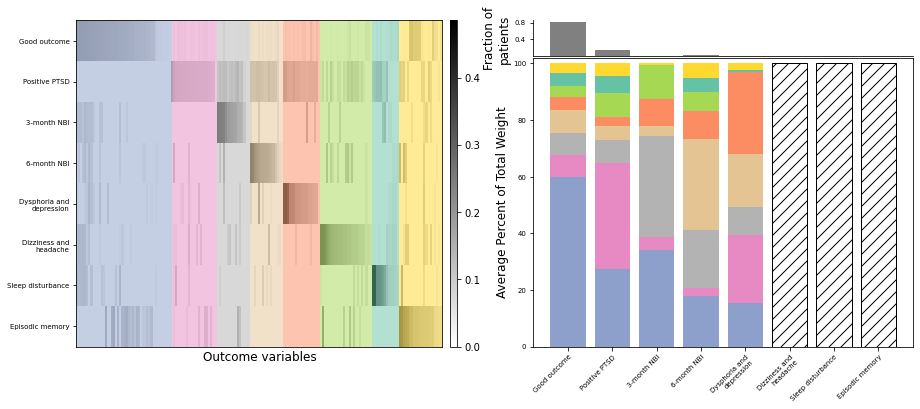

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax_hm = axes[0]
ax_bp = axes[1]
ax_bp2 = make_axes_locatable(ax_bp).append_axes("top", 0.5, pad=0.02, sharex=ax_bp)
axes = [ax_hm, ax_bp2, ax_bp]
factor_order = nmfplot(oc_weights, oc_bases, axes=axes, bases_order=False, bases_labels=oc_bases_labels, 
                       fontsize='large', heatmap_xlabel="Outcome variables", labelsize='x-small', palette=oc_colors)

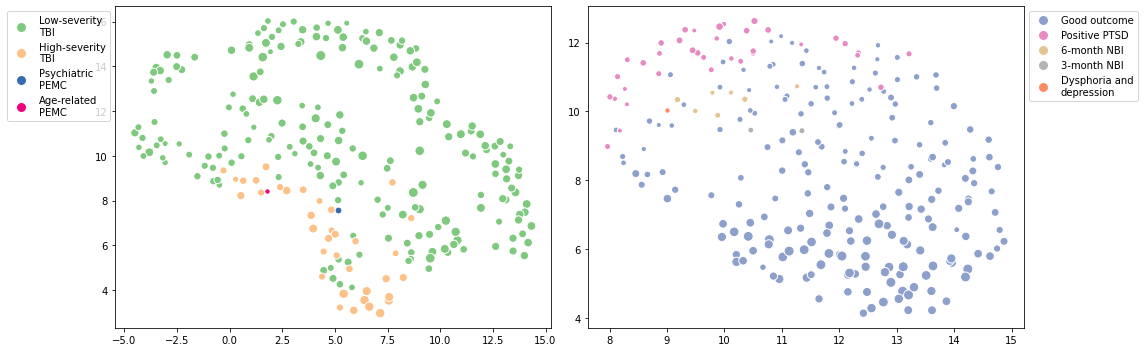

In [16]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plot_umap_nmf_max(bm_emb, bm_weights, bm_bases_labels, min_dist=1.0, palette=bm_colors)
plt.subplot(1,2,2)
plot_umap_nmf_max(oc_emb, oc_weights, oc_bases_labels, right=True, palette=oc_colors)
plt.tight_layout()
plt.savefig("nmf_labelled_umap.png", dpi=200)

# multi-panel figure 
- a, b, c - bm barplot, bm heatmap, bm umap-pie-chart
- d, e, f - oc barplot, oc heatmap, oc umap-pie-chart

/Users/ajtritt/projects/activ/mmda.git/activ/nmf/viz.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(row_labels, fontsize=fontsize)
/Users/ajtritt/projects/activ/mmda.git/activ/nmf/viz.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(row_labels, fontsize=fontsize)


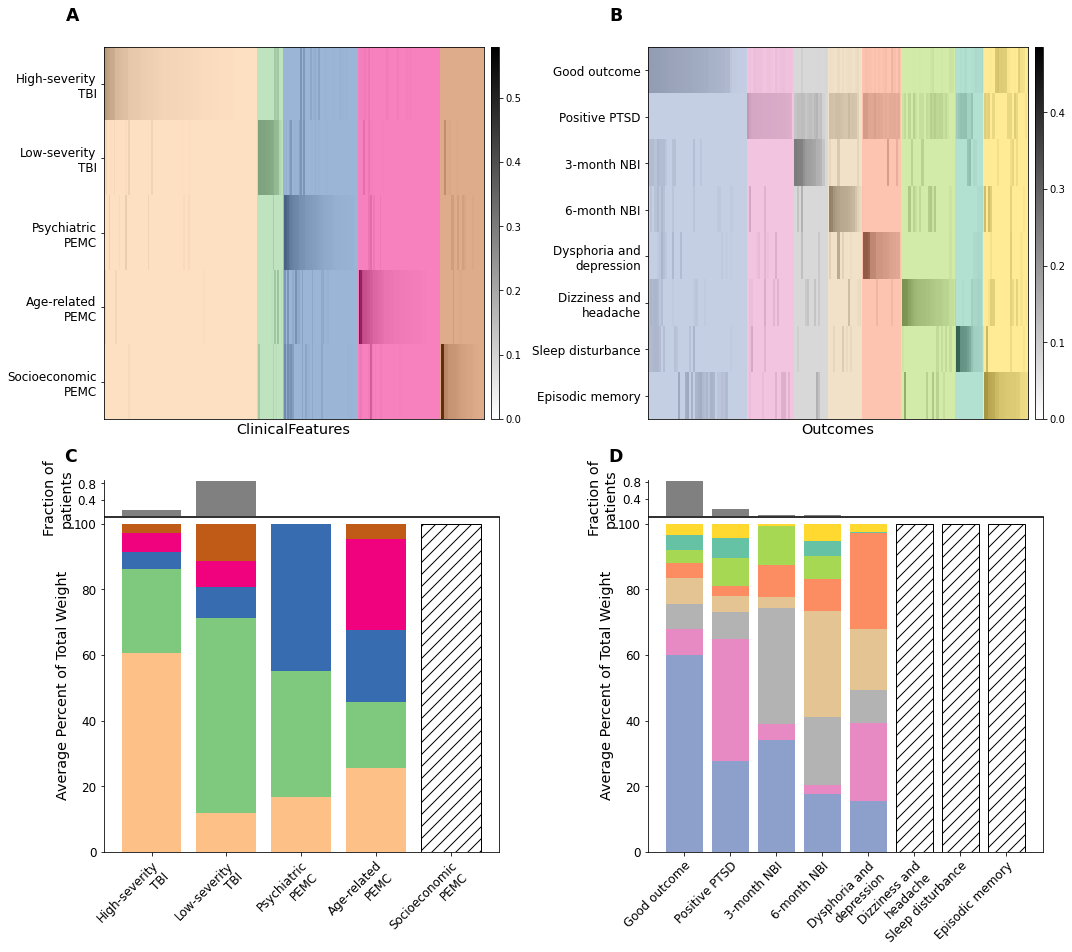

In [17]:
def add_label(ax, label, x=-0.1, y=1.07):
    ax.text(x, y, label,  weight='bold', transform=ax.transAxes, size='xx-large')    
#################################################

fig_width = 15
fig_height = 13.33

fig, axes = plt.subplots(2, 2, figsize=(fig_width, fig_height))

axA = axes[0, 0]
axC = axes[1 ,0]
axB = axes[0, 1]
axD = axes[1, 1]


# below height and pad are in inches
axC_bar = make_axes_locatable(axC).append_axes("top", 0.5, pad=0.02, sharex=axC)
axD_bar = make_axes_locatable(axD).append_axes("top", 0.5, pad=0.02, sharex=axD)


fs = 'x-large'
ls = 'large'

nmfplot(bm_weights, bm_bases, axes=[axA, axC_bar, axC], bases_order=False, bases_labels=bm_bases_labels, 
        fontsize=fs, heatmap_xlabel='ClinicalFeatures', palette=bm_colors, labelsize=ls)



nmfplot(oc_weights, oc_bases, axes=[axB, axD_bar, axD], bases_order=False, bases_labels=oc_bases_labels, 
        fontsize=fs, heatmap_xlabel='Outcomes', palette=oc_colors, labelsize=ls)


for ax, lbl in zip([axA, axB] , "AB"):
    add_label(ax, lbl)

for ax, lbl in zip([axC_bar, axD_bar], "CD"):
    add_label(ax, lbl, y=1.5)

plt.tight_layout()
fig_path = '../../paper/MultiPanel_latent_features_NMF.png'
fig_dpi = 200
plt.tight_layout()
plt.savefig(fig_path, dpi=fig_dpi)

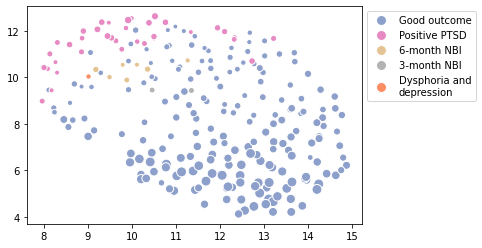

In [18]:
plot_umap_nmf_max(oc_emb, oc_weights, oc_bases_labels, right=True, palette=oc_colors)

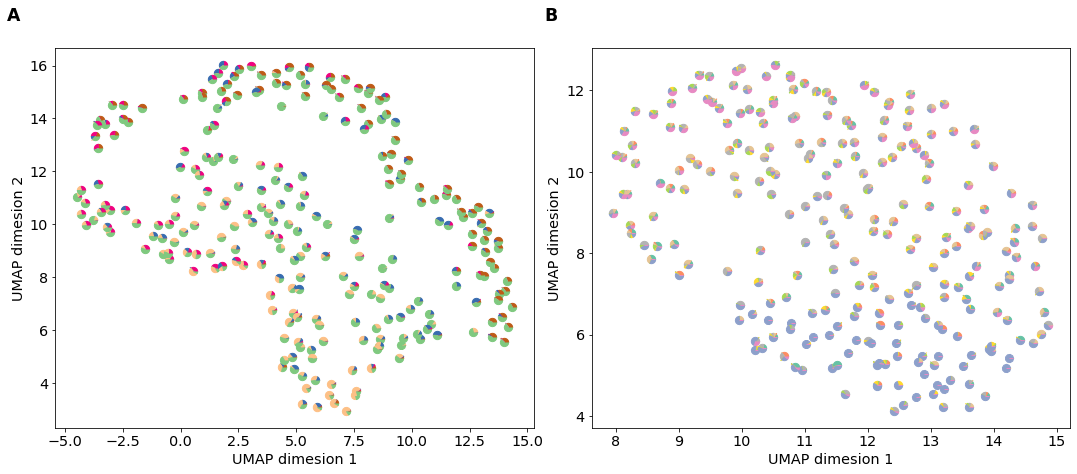

In [19]:
fig_width = 15
fig_height = 6.67

fig, axes = plt.subplots(1, 2, figsize=(fig_width, fig_height))
axE = axes[0]
axF = axes[1]

plot_umap_nmf_piechart(bm_weights/np.sum(bm_bases != 0, axis=1), bm_emb, s=70, ax=axE, fontsize=fs, palette=bm_colors)
plot_umap_nmf_piechart(oc_weights/np.sum(oc_bases != 0, axis=1), oc_emb, s=70, ax=axF, fontsize=fs, palette=oc_colors)

for ax, lbl in zip([axE, axF] , "AB"):
    add_label(ax, lbl)
    
plt.tight_layout()
fig_path = '../../paper/MultiPanel_latent_features_UMAP.png'
fig_dpi = 200
plt.savefig(fig_path, dpi=fig_dpi)

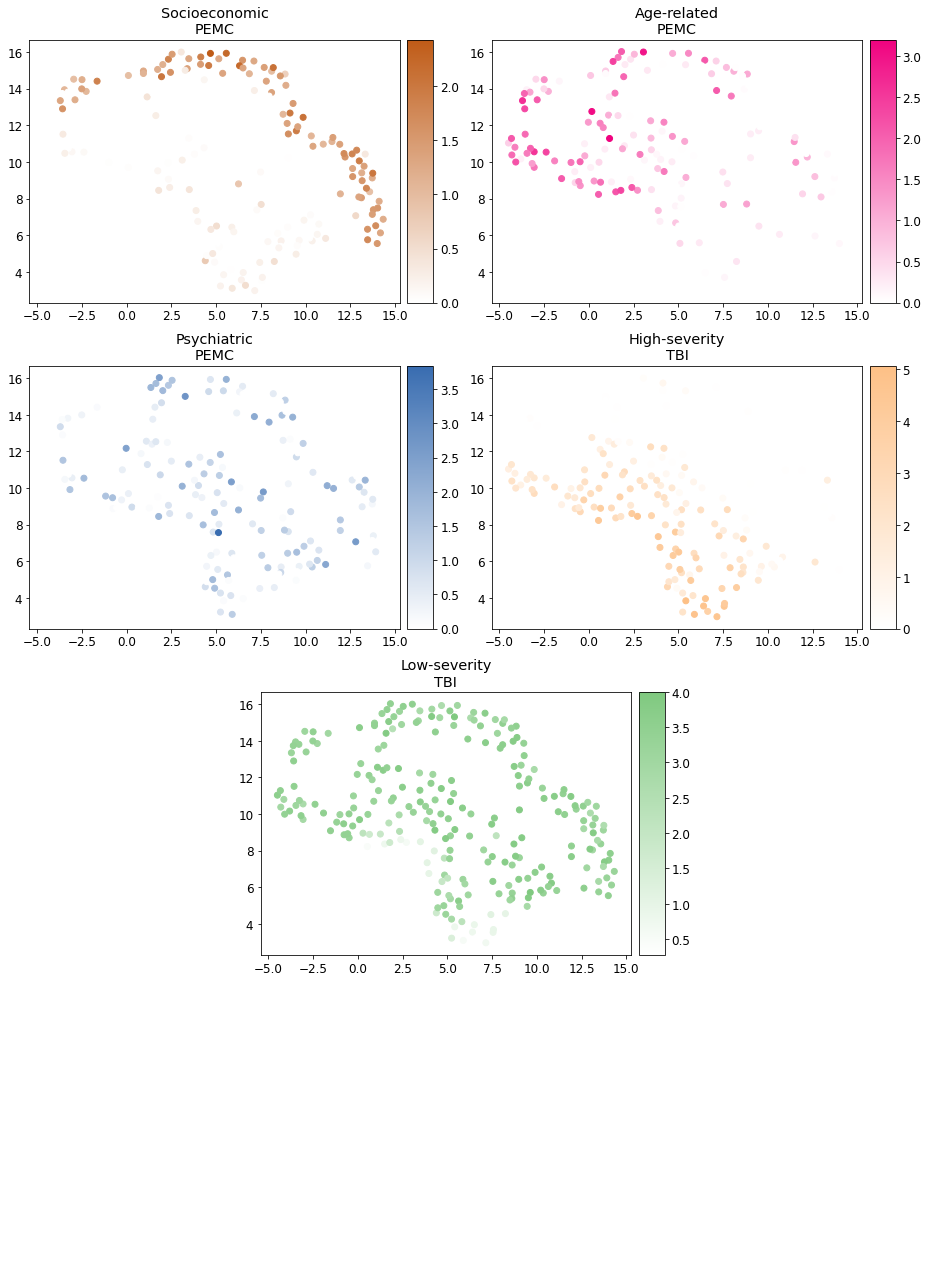

In [20]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(4):
    col = i%2
    axes.append(fig.add_subplot(gs[i//2, col*2:col*2+2]))
axes.append(fig.add_subplot(gs[2, 1:3]))
fig.add_subplot(gs[3, :]).axis('off')
cmaps = [mpc.LinearSegmentedColormap.from_list('mycmap', [(1.0,1.0,1.0), c]) for c in bm_colors]
plot_umap_nmf_weight(bm_emb, bm_weights, axes, bm_bases_labels, cmaps=cmaps)
plt.tight_layout(h_pad=0.99, w_pad=0.9999)
plt.savefig('../../paper/biomarker_weights_umap.png', dpi=200)

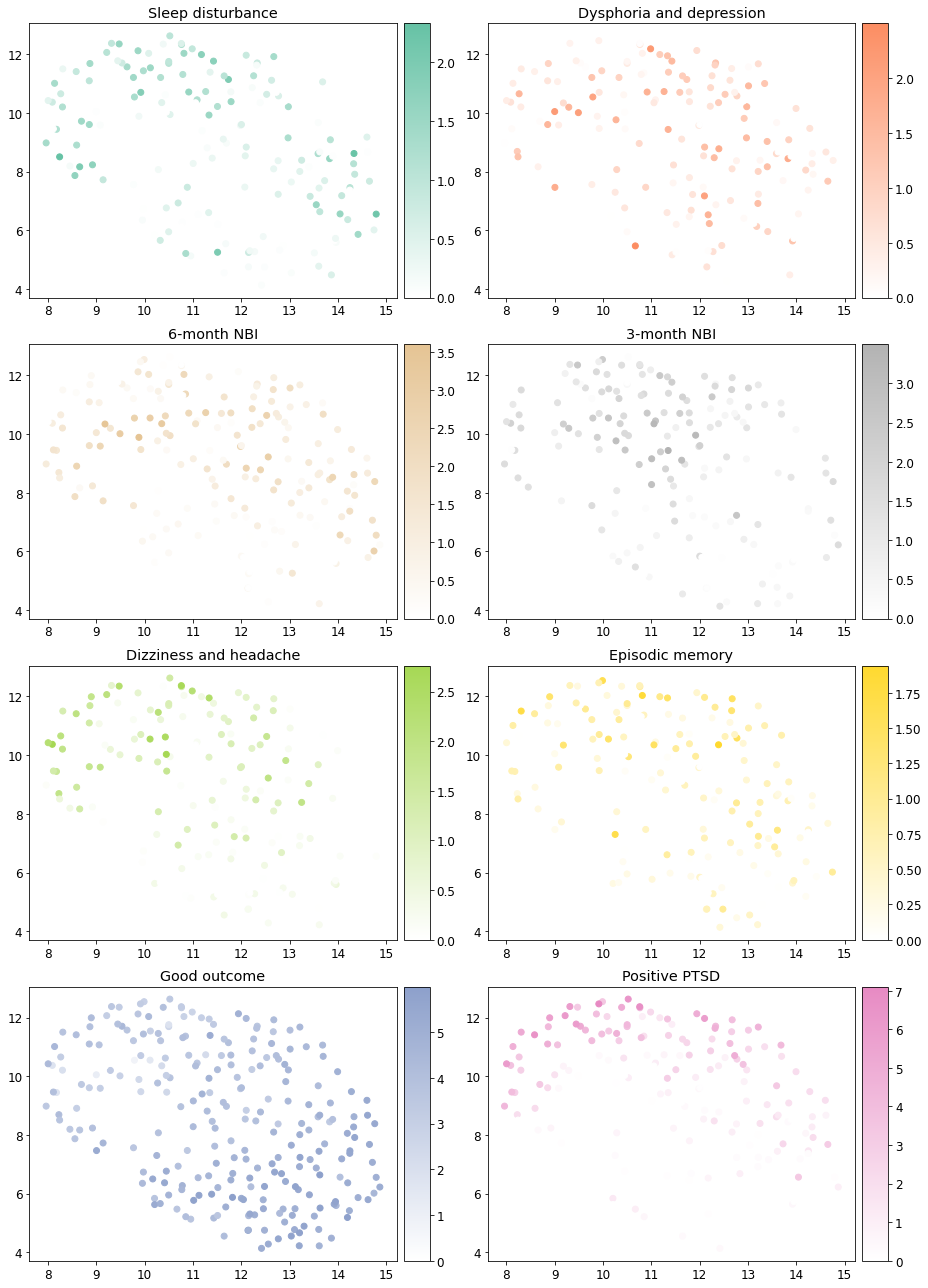

In [21]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(8):
    col = i % 2
    row = i // 2
    axes.append(fig.add_subplot(gs[row, col*2:col*2+2]))

cmaps = colormaps = [mpc.LinearSegmentedColormap.from_list('mycmap', [(1.0,1.0,1.0), c]) for c in oc_colors]
plot_umap_nmf_weight(oc_emb, oc_weights, axes, [s.replace('\n', ' ') for s in oc_bases_labels], cmaps=cmaps)
plt.tight_layout(h_pad=0.99, w_pad=0.9999)
plt.savefig('../../paper/outcome_weights_umap.png', dpi=200)

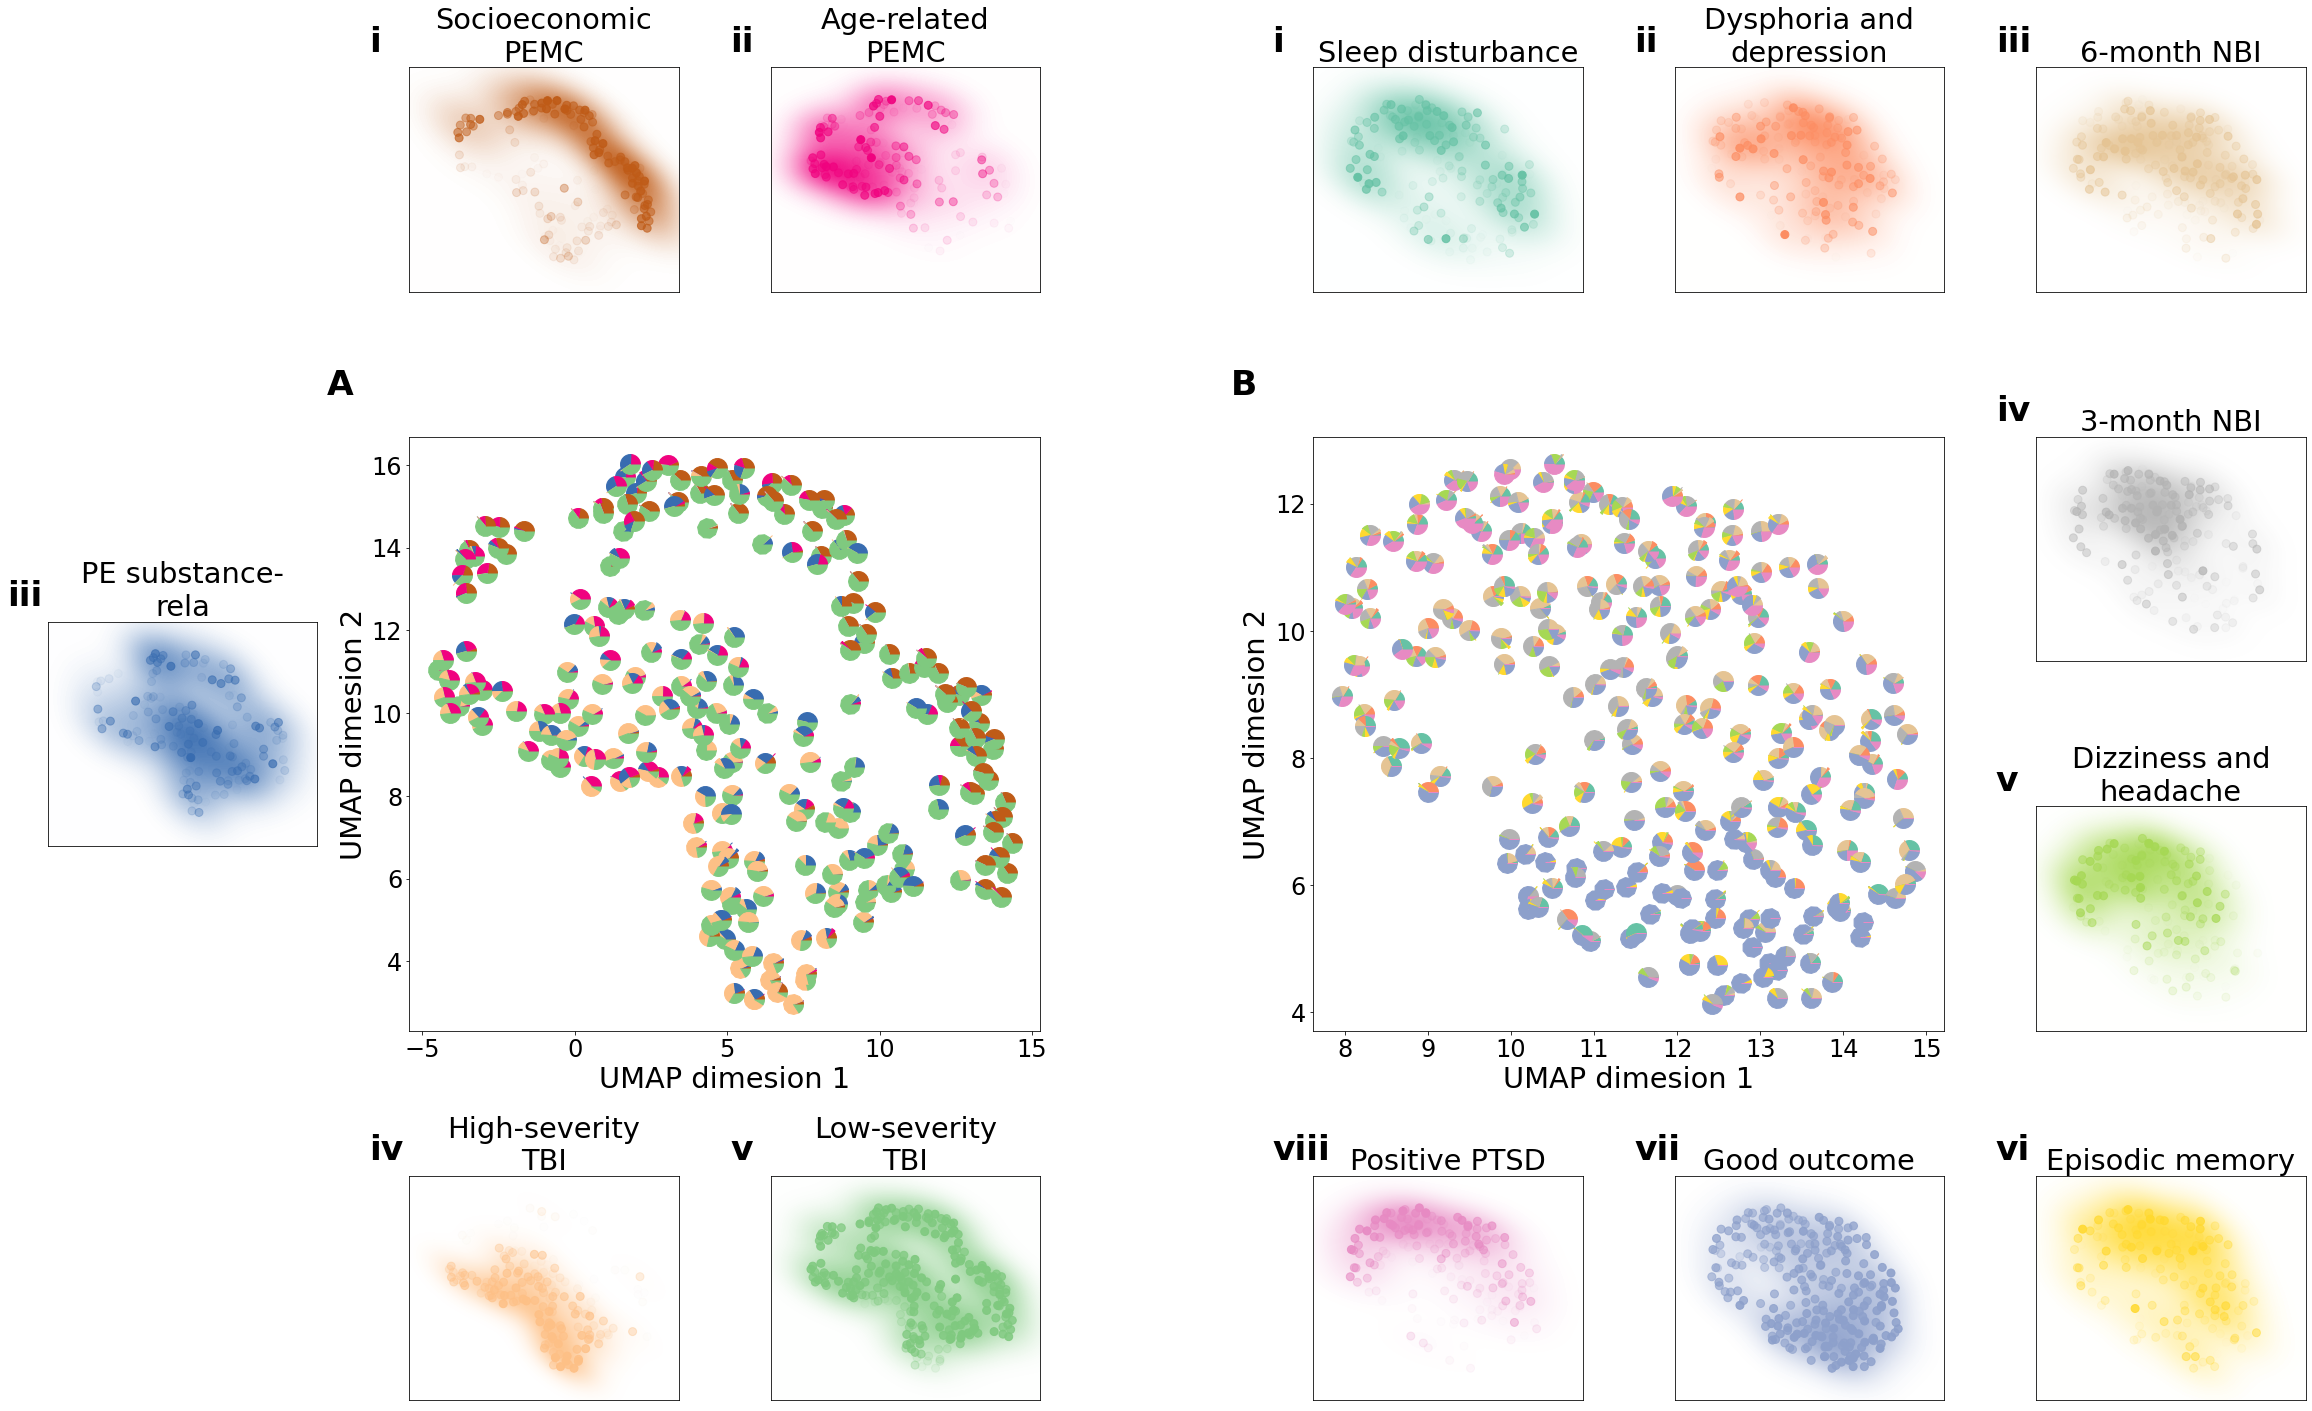

In [22]:
fig = plt.figure(figsize=(32.5, 20))
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
gs = mgrid.GridSpec(8, 13, figure=fig)

def add_label(ax, label, x=-0.15, y=1.07, size='xx-large'):
    ax.text(x, y, label,  weight='bold', transform=ax.transAxes, size=size) 

ax_BmMain = fig.add_subplot(gs[2:-2, 2:6])
ax_OcMain = fig.add_subplot(gs[2:-2, 7:11])

axes = list()
axes.append(fig.add_subplot(gs[:2, 2:4]))
axes.append(fig.add_subplot(gs[:2, 4:6]))
axes.append(fig.add_subplot(gs[3:5, :2]))
axes.append(fig.add_subplot(gs[6:, 2:4]))
axes.append(fig.add_subplot(gs[6:, 4:6]))

axes.append(fig.add_subplot(gs[:2, 7:9]))
axes.append(fig.add_subplot(gs[:2, 9:11]))
axes.append(fig.add_subplot(gs[:2, 11:]))
axes.append(fig.add_subplot(gs[2:4, 11:]))
axes.append(fig.add_subplot(gs[4:6, 11:]))
axes.append(fig.add_subplot(gs[6:, 11:]))
axes.append(fig.add_subplot(gs[6:, 9:11]))
axes.append(fig.add_subplot(gs[6:, 7:9]))


sckw = {'s':64}

for lbl, ax in zip(('i', 'ii', 'iii', 'iv', 'v'), axes[:5]):
    add_label(ax, lbl, size='xx-large')
    
for lbl, ax in zip(('i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii'), axes[5:]):
    add_label(ax, lbl, size='xx-large')
    

bm_labels = bm_bases_labels.copy()
bm_labels[2] = 'PE substance-\nrelated'

plot_umap_nmf_weight_kde(bm_emb, bm_weights, bm_colors, bases_labels=bm_labels, ax=axes[:5], scatter=True, cbar=False, scatter_kw=sckw)
plot_umap_nmf_weight_kde(oc_emb, oc_weights, oc_colors, bases_labels=oc_bases_labels, ax=axes[5:], scatter=True, cbar=False, scatter_kw=sckw)


plot_umap_nmf_piechart(bm_weights/np.sum(bm_bases != 0, axis=1), bm_emb, s=400, ax=ax_BmMain, fontsize='x-large', palette=bm_colors)
plot_umap_nmf_piechart(oc_weights/np.sum(oc_bases != 0, axis=1), oc_emb, s=400, ax=ax_OcMain, fontsize='x-large', palette=oc_colors)

for lbl, ax in zip('AB', (ax_BmMain, ax_OcMain)):
    add_label(ax, lbl, size='xx-large', x=-0.13)
    ax.tick_params('both', labelsize='large')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_in_layout(False)
    

gs.tight_layout(fig)
plt.savefig('../../paper/umap_piecharts_kde.png', dpi=200)

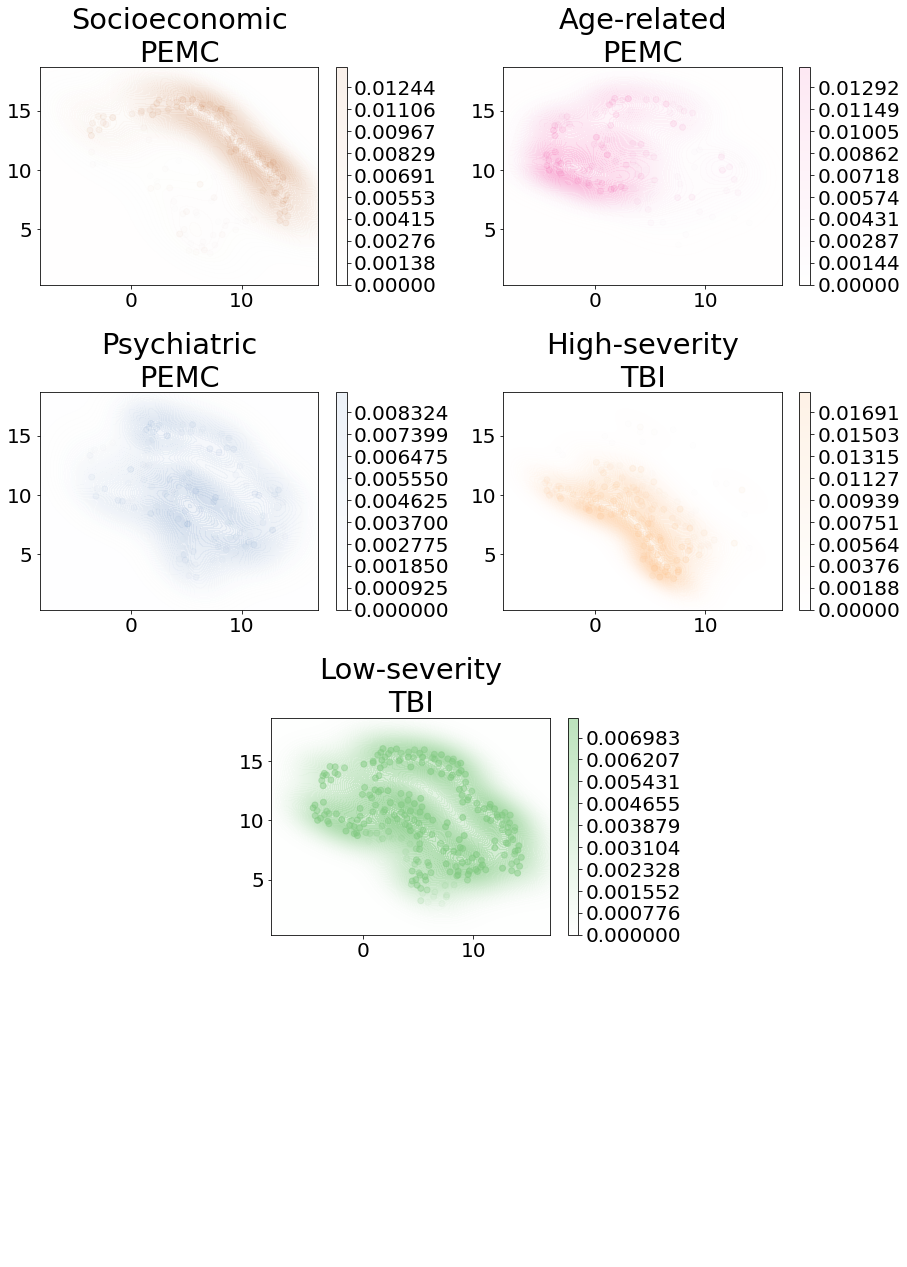

In [23]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(4):
    col = i%2
    axes.append(fig.add_subplot(gs[i//2, col*2:col*2+2]))
axes.append(fig.add_subplot(gs[2, 1:3]))
fig.add_subplot(gs[3, :]).axis('off')

plot_umap_nmf_weight_kde(bm_emb, bm_weights, bm_colors, bases_labels=bm_bases_labels, ax=axes, alpha=None, scatter=True)
plt.tight_layout()
plt.savefig('../../paper/biomarker_weights_umap_kde.png', dpi=200)

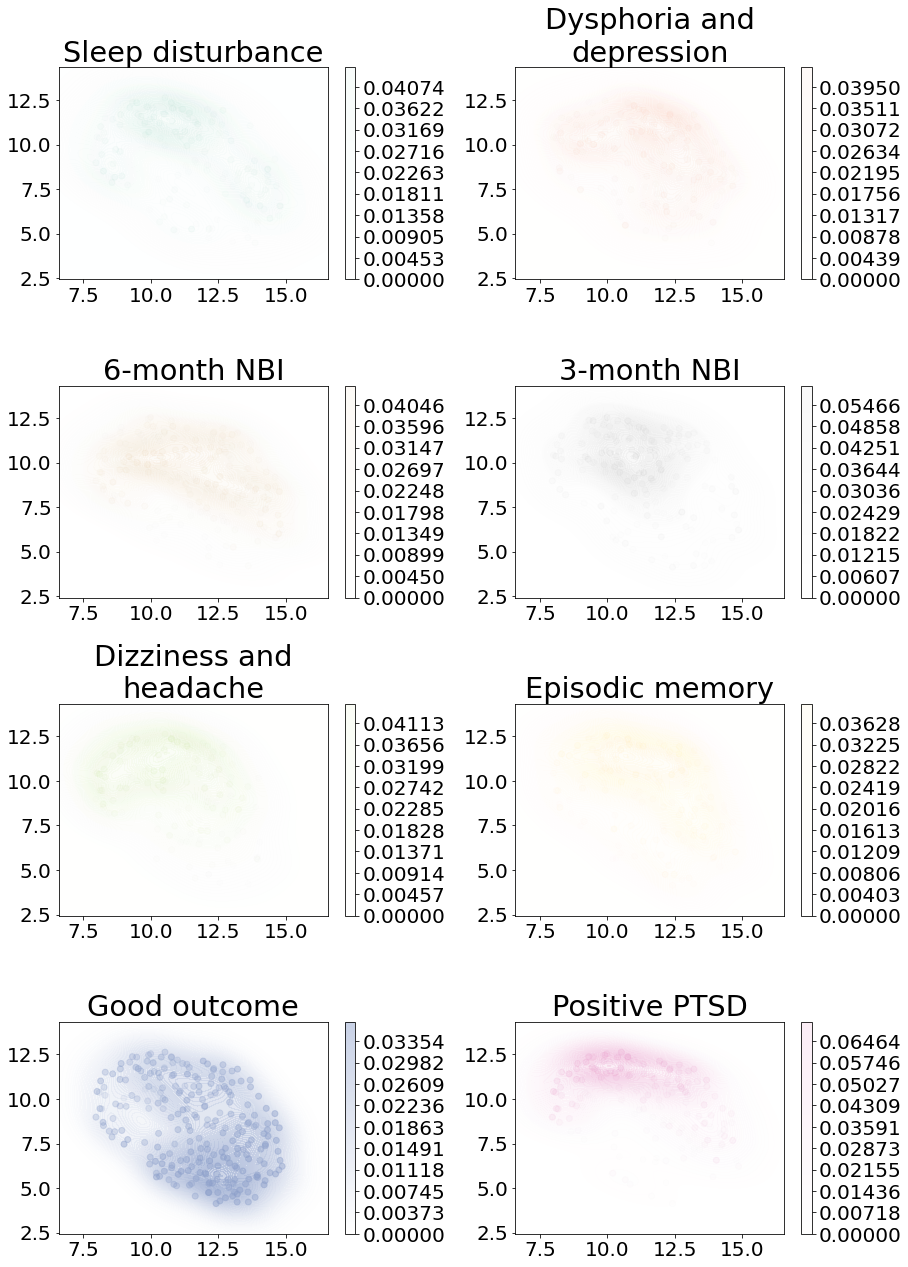

In [24]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(8):
    col = i % 2
    row = i // 2
    axes.append(fig.add_subplot(gs[row, col*2:col*2+2]))

plot_umap_nmf_weight_kde(oc_emb, oc_weights, oc_colors, bases_labels=[s for s in oc_bases_labels], ax=axes, alpha=None, scatter=True)
plt.tight_layout(h_pad=0.99, w_pad=0.9999)
plt.savefig('../../paper/outcome_weights_umap_kde.png', dpi=200)

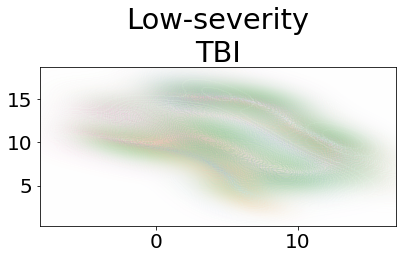

In [25]:
plot_umap_nmf_weight_kde(bm_emb, bm_weights, bm_colors, bases_labels=bm_bases_labels, alpha=0.2)
plt.tight_layout()
plt.savefig('../../paper/biomarker_weights_umap_kde_layered.png', dpi=200)

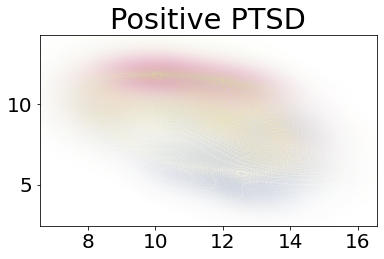

In [69]:
plot_umap_nmf_weight_kde(oc_emb, oc_weights, oc_colors, bases_labels=[s.replace('\n', ' ') for s in oc_bases_labels], alpha=0.2)
plt.tight_layout()
plt.savefig('../../paper/outcomes_weights_umap_kde_layered.png', dpi=200)

array([[0.00000000e+00, 5.67252537e-02, 0.00000000e+00, ...,
        5.59294843e-02, 0.00000000e+00, 0.00000000e+00],
       [1.23422276e-06, 1.93969317e-13, 1.10021183e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.91020144e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.11690516e-11, ...,
        0.00000000e+00, 1.85698695e-01, 1.32702637e-01],
       [0.00000000e+00, 1.51129678e-01, 2.11550388e-03, ...,
        1.63843796e-01, 1.54071595e-01, 1.36882150e-01],
       [0.00000000e+00, 0.00000000e+00, 9.42415540e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

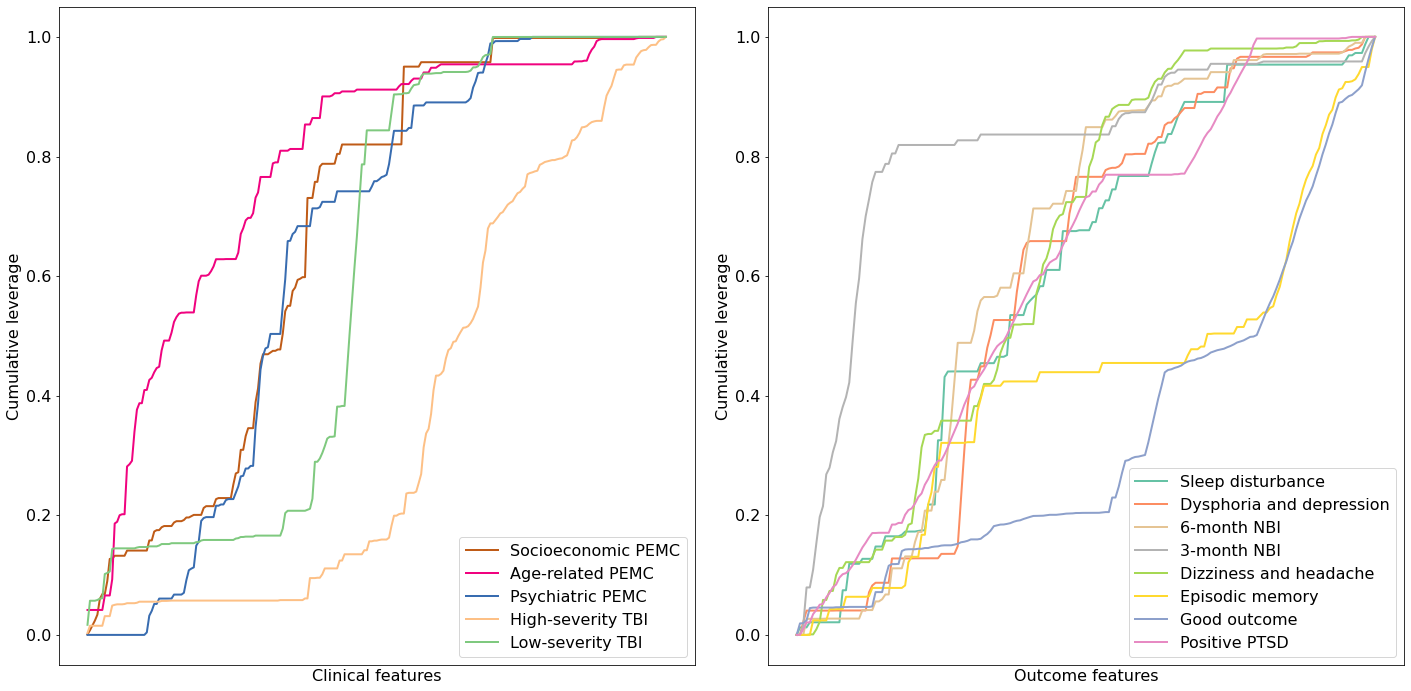

In [79]:
def plot_leverage(bases, colors, labels, ax):
    for i in range(len(labels)):
        x = np.cumsum(bases[i, :])
        x /= x[-1]
        ax.plot(x, color=colors[i], label=labels[i].replace('\n', ' '), lw=2)
    ax.legend(fontsize=16, loc='lower right')
    ax.tick_params('x', bottom=False, labelbottom=False)
    ax.tick_params('y', labelsize=16)
    ax.set_ylabel('Cumulative leverage', fontsize=16)

fig, axes = plt.subplots(1, 2, figsize=(20,10))
plot_leverage(bm_bases, bm_colors, bm_bases_labels, axes[0])
axes[0].set_xlabel('Clinical features', fontsize=16)
plot_leverage(oc_bases, oc_colors, oc_bases_labels, axes[1])
axes[1].set_xlabel('Outcome features', fontsize=16)
plt.tight_layout()
plt.savefig('../../paper/bases_cumulative.png', dpi=200)

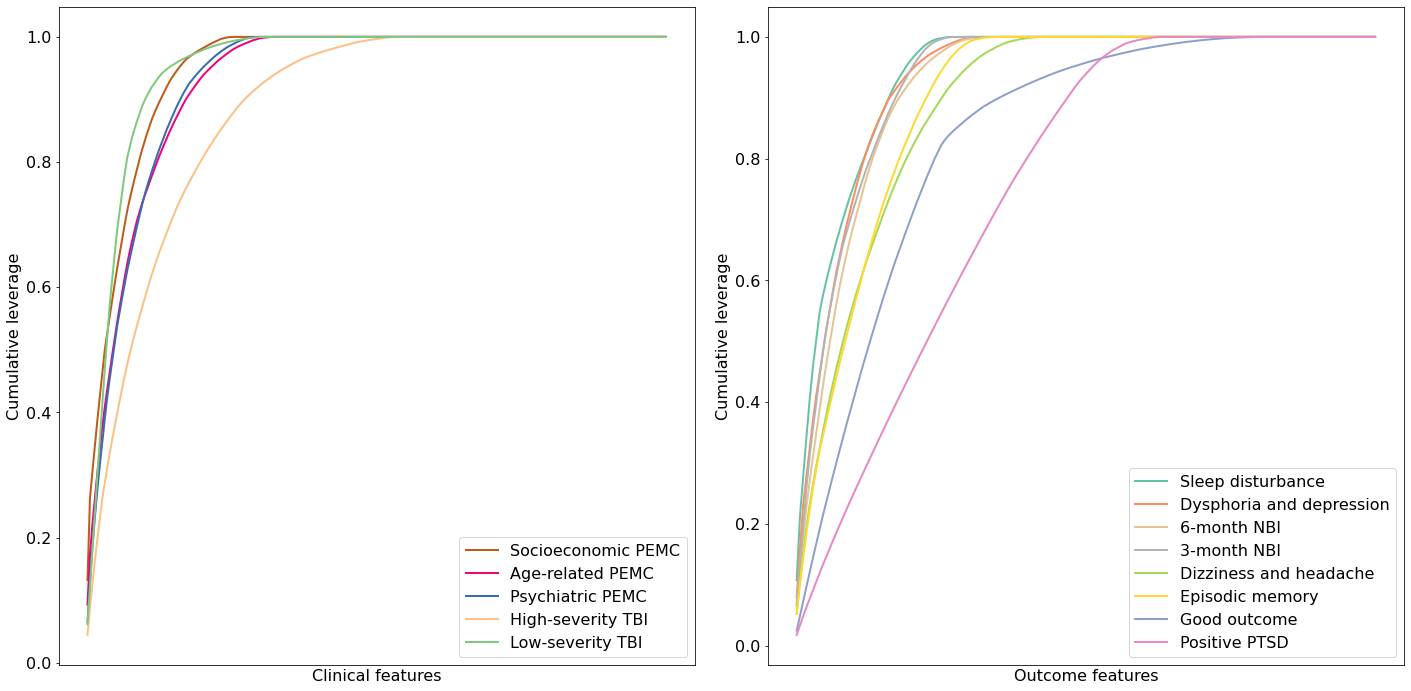

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
plot_leverage(np.sort(bm_bases, axis=1)[:, ::-1], bm_colors, bm_bases_labels, axes[0])
axes[0].set_xlabel('Clinical features', fontsize=16)
plot_leverage(np.sort(oc_bases, axis=1)[:, ::-1], oc_colors, oc_bases_labels, axes[1])
axes[1].set_xlabel('Outcome features', fontsize=16)
plt.tight_layout()
plt.savefig('../../paper/bases_cumulative_sorted.png', dpi=200)